Specify the csv data files and the corresponding plot labels in the first cell below. Each CSV file represents data for a specific configuration e.g. Jacobi program with ROC_SHMEM run on the AMD Fund MI100 node. Each row of the csv file represents a specific problem size run with certain number of GPUs/processors along with the performance numbers as follows:
```
<program name>, <nx>, <ny>, <niter>, <nccheck>, <nprocs/ngpus>, 1, <total time>, <serial time>, <comms time>
rccl_overlap, 8192, 8192, 1000, 1, 2, 1, 0.431098, 0.759678, 0.064356
```

If the data files have a consistent format, that is, if the columns actually align as expected, then you should be able to directly go to the last cell for tweaking the plot settings.

In [10]:
data_files = []
plot_labels = []
data_files.append("data/jacobi_rocshmem_amdfund_mi1008x_69303.csv")
plot_labels.append("AMD Fund 8xMI100\n ROC_SHMEM")

data_files.append("data/jacobi_rccl_amdfund_mi1008x_69371.csv")
plot_labels.append("AMD Fund 8xMI100\n RCCL")

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import csv
import math

The `ScalingData` class reads and holds the performance scaling data for a config.

In [3]:
class ScalingData:
    def __init__(self, fname):
        self.filename = fname
        # Initialize the lists to be read in from the data file
        # Column 0 is the name of the test
        self.nx = []             # 1
        self.ny = []             # 2
        self.niter = []          # 3
        self.nccheck = []        # 4
        self.nprocs = []         # 5
        # 1                      # 6
        self.total_time = []     # 7
        self.serial_time = []    # 8
        self.comms_time = []     # 9

        self.read_file()

    def read_file(self):
        with open(self.filename, "r") as csvfile:
            csvreader = csv.reader(csvfile)
            for row in csvreader:
                self.nx.append(int(row[1]))
                self.ny.append(int(row[2]))
                self.niter.append(int(row[3]))
                self.nccheck.append(int(row[4]))
                self.nprocs.append(int(row[5]))
                self.total_time.append(float(row[7]))
                self.serial_time.append(float(row[8]))
                self.comms_time.append(float(row[9]))


The `config` list holds the performance data for various configurations (comms library, machine, node) as `ScalingData` objects.

In [4]:
config = []

for fname in data_files:
    config.append(ScalingData(fname))

In [5]:
# for debugging
print(config[0].total_time)
print(config[0].serial_time)
print(config[0].comms_time)

[2.615462, 1.352729, 0.934732, 0.7547]
[5.022254, 5.033848, 5.038655, 4.934708]
[0.043568, 0.046065, 0.044587, 0.070838]


Create a dataframe where rows are the different configs and columns are the performance timings for a specific config, e.g. the total wall time for the test with increasing no. of GPUs.

In [6]:
nrows = len(config)
columns = ['Team', '1 GPU']
for nprocs in config[0].nprocs:
    columns.append(str(nprocs) + ' GPUs')

df_total_time = pd.DataFrame(np.nan, index=range(nrows), columns=columns)
df_total_time['Team'] = df_total_time['Team'].astype(str)

print(df_total_time)


  Team  1 GPU  2 GPUs  4 GPUs  6 GPUs  8 GPUs
0  nan    NaN     NaN     NaN     NaN     NaN
1  nan    NaN     NaN     NaN     NaN     NaN


In [7]:
# print all config filenames to help with setting plot team names manually
for cfg in config:
    print(cfg.filename)

data/jacobi_rocshmem_amdfund_mi1008x_69303.csv
data/jacobi_rccl_amdfund_mi1008x_69371.csv


Fill the dataframe

In [8]:

for row_index in range(df_total_time.shape[0]):
    df_total_time.iloc[row_index, 0] = plot_labels[row_index]
    df_total_time.iloc[row_index, 1] = np.mean(config[row_index].serial_time)
    for col_index in range(2, df_total_time.shape[1]):
        df_total_time.iloc[row_index, col_index] = \
            config[row_index].total_time[col_index-2]

print(df_total_time)
type(df_total_time)

                           Team     1 GPU    2 GPUs    4 GPUs    6 GPUs  \
0  AMD Fund 8xMI100\n ROC_SHMEM  5.007366  2.615462  1.352729  0.934732   
1       AMD Fund 8xMI100\n RCCL  0.761366  0.431098  0.250325  0.199068   

     8 GPUs  
0  0.754700  
1  0.191923  


pandas.core.frame.DataFrame

Plot the grouped bar chart

Text(0.5, 1.0, 'Jacobi solver, 1000 iters\nDomain size: 8192x8192')

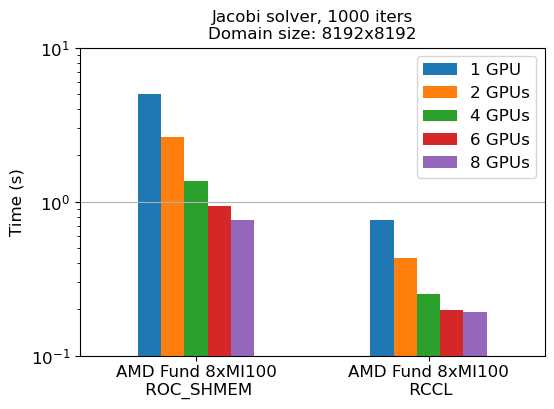

In [9]:
fs = 12

axes1=df_total_time.plot(
    x='Team',
    kind='bar',
    stacked=False,
    rot=0, xlabel='', figsize=(6, 4),
    fontsize=fs,
    legend=None)
axes1.grid(axis='y')
axes1.set_ylim(0.1,10)
axes1.set_yscale('log')
#axes1.set_yticks(ticks=np.power(10, np.arange(-1.0, 1.5, 0.5)))
axes1.legend(fontsize = fs)
axes1.set_ylabel("Time (s)", fontsize = fs)
plt.title('Jacobi solver, 1000 iters\n'
          'Domain size: 8192x8192',
          fontsize = fs, horizontalalignment='center')
#plt.savefig('jacobi.pdf')
